**Spectral Clustering** is a clustering method based on elements from graph theory - data points are interpreted as vertices in a graph. A graph displaying a similarity graph and matrix.The lengths of the edges between datapoints can be represented in a affinity/similarity matrix. The affinity matrix is provided as an input and consists of a quantitative assessment of the relative similarity of each pair of points in the dataset. Spectral Clustering then works by embedding the data points of the partitioning problem into the subspace of the k eigenvectors with the smallest corresponding eigenvalues of a normalized affinity matrix. This implies running standard clustering methods such as k-means clustering on a reduced dataset.
<br> <br>
It makes use of the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. <br> <br>
The goal of spectral clustering is to cluster data that is connected but not necessarily compact or clustered within convex boundaries. The power of Spectral Clustering is to identify non-compact clusters in  a single data set. <br>
One spectral clustering technique is the normalized cuts algorithm or Shi–Malik algorithm. It partitions points into two sets (B1,B2) based on the eigenvector v corresponding to the second-smallest eigenvalue of the symmetric normalized Laplacian.


Plotting raw datasets


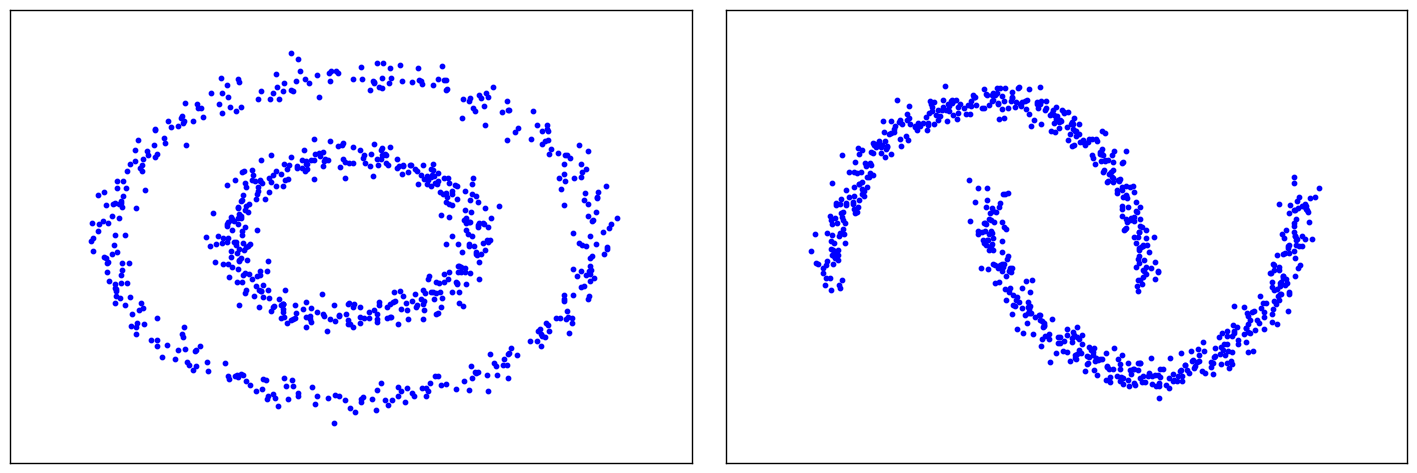

Clustering:


/usr/local/python/python-2.7/std/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


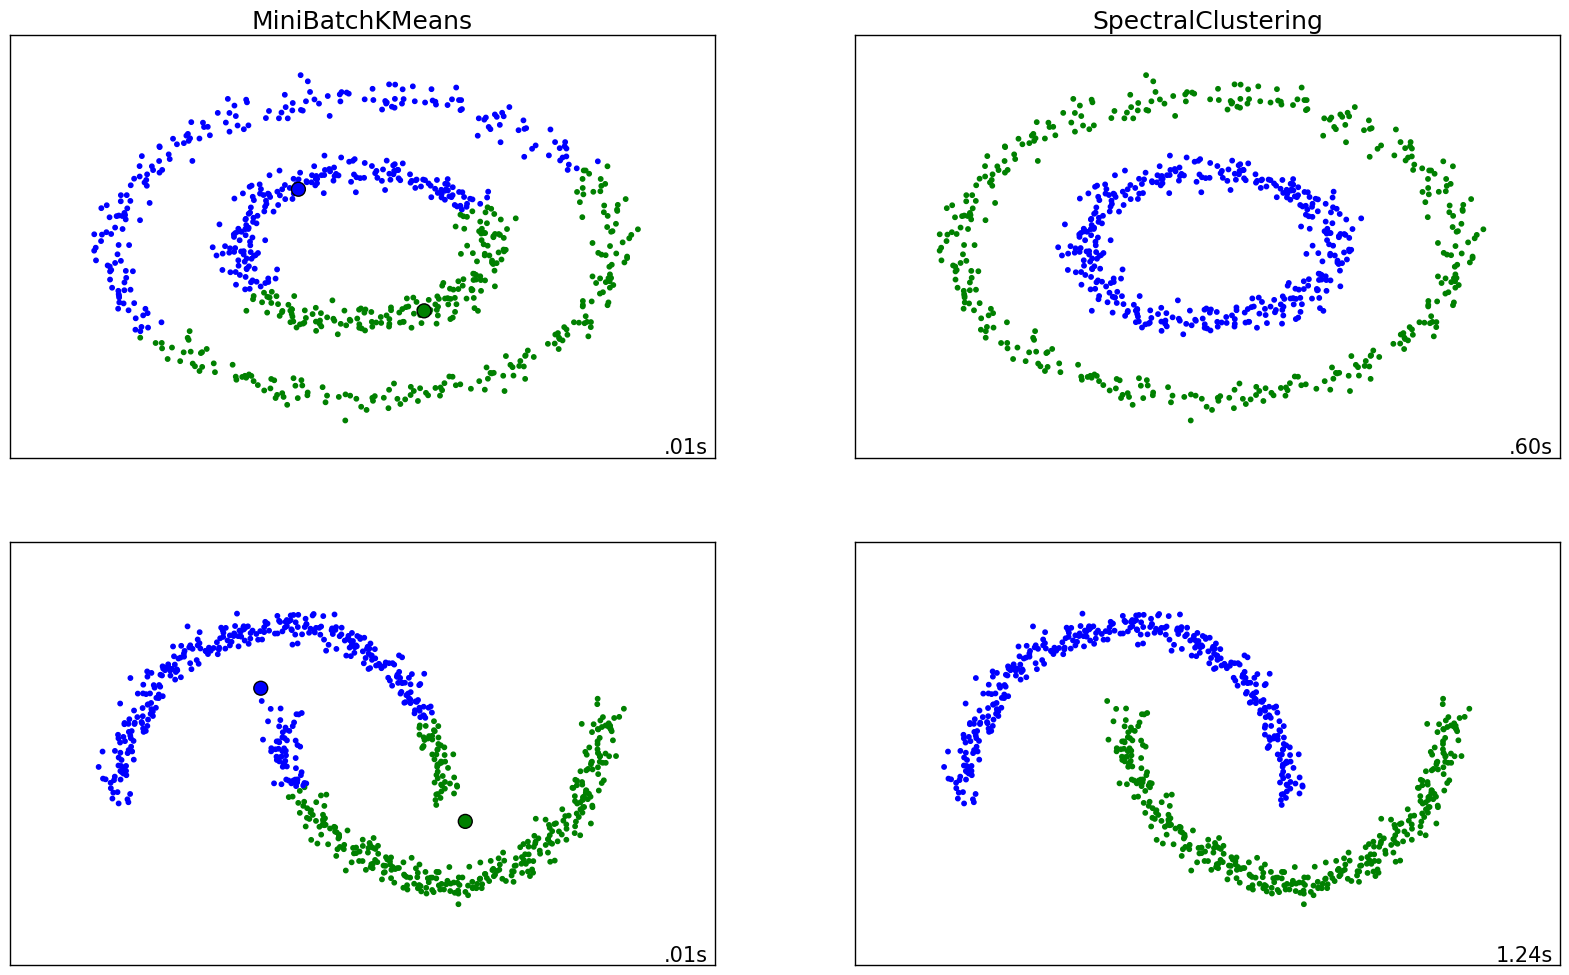

In [1]:
import time

import pylab as pl
import numpy as np

from sklearn               import cluster, datasets
from sklearn.metrics       import euclidean_distances
from sklearn.neighbors     import kneighbors_graph
from sklearn.preprocessing import StandardScaler

%matplotlib inline

pl.rcParams['figure.figsize'] = 20,12
np.random.seed(0)

# Generate datasets. 
n_samples = 750
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons   = datasets.make_moons  (n_samples=n_samples, noise=.05)

colors = np.array([x for x in 'bg'])

pl.figure(figsize=(14, 9.5))
pl.subplots_adjust(left=.001, right=.999, bottom=.001, top=.96, wspace=.05, hspace=.01)
plot_num = 1

print ('Plotting raw datasets')
datasets = [noisy_circles, noisy_moons]

for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    '''
    Normalize dataset for easier parameter selection
    --Standardize features by removing the mean and scaling to unit variance
    --Fit to data, then transform it.
    
    sklearn's transform's fit() just calculates the parameters (μ and σ in case of StandardScaler) and
    saves them as an internal objects state. Afterwards, you can call its transform() method to apply
    the transformation to a particular set of examples.

    fit_transform() joins these two steps and is used for the initial fitting of parameters on the 
    training set x, but it also returns a transformed x′. Internally, it just calls first fit() and
    then transform() on the same data.
    '''
    X = StandardScaler().fit_transform(X)

    # plot
    pl.subplot(2, 2, plot_num)
    pl.scatter(X[:, 0], X[:, 1], color='b', s=10)

    pl.xlim(-2.5, 2.5)
    pl.ylim(-2.5, 2.5)
    pl.xticks(())
    pl.yticks(())
    plot_num += 1

pl.show()

plot_num = 1
n_clusters=2
print ('Clustering:')
for i_dataset, dataset in enumerate(datasets): 

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # connectivity matrix for structured Ward
    # Computes the (weighted) graph of k-Neighbors for points in X
    connectivity = kneighbors_graph(X, n_neighbors=10)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Compute distances
    # distances = np.exp(-euclidean_distances(X))
    # Considering the rows of X (and Y=X) as vectors, compute the distance matrix between each pair of vectors.
    distances = euclidean_distances(X)

    # create clustering estimators
    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity='nearest_neighbors',
                                          assign_labels='discretize')
    
    for algorithm in [two_means, spectral]:
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        pl.subplot(len(datasets), 2, plot_num)
        if i_dataset == 0:
            pl.title(str(algorithm).split('(')[0], size=18)
        pl.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            pl.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        pl.xlim(-2.5, 2.5)
        pl.ylim(-2.5, 2.5)
        pl.xticks(())
        pl.yticks(())
        pl.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                transform=pl.gca().transAxes, size=15,
                horizontalalignment='right')
        plot_num += 1

pl.show()

#### Image Segmentation - circles using spectral clustering
Goal is to identify 4 overlapping circular clusters.  It is a simple problem, even simple Kmeans would probably be fine because the clusters are compact. The point is to separate the clusters from the background.

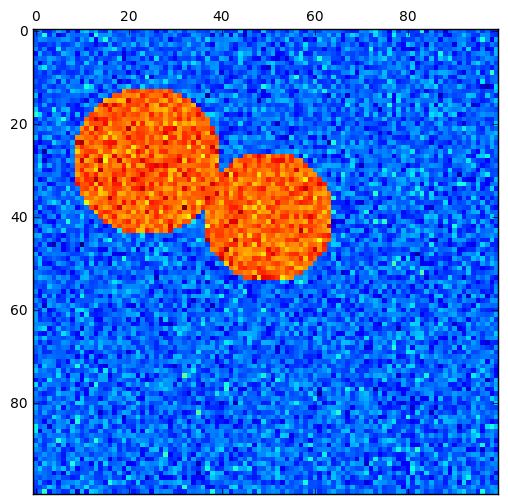

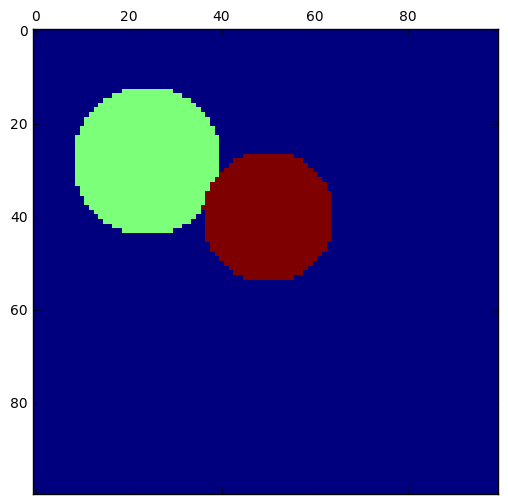

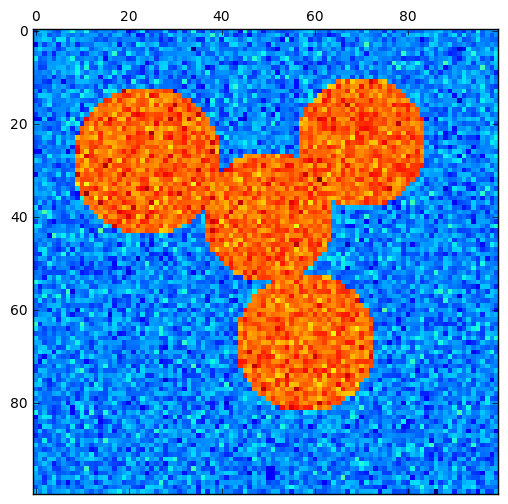

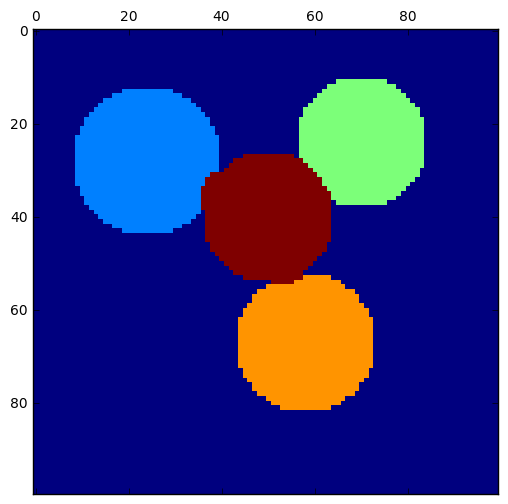

In [21]:
import pylab as pl
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
pl.rcParams['figure.figsize'] = 10,6

###############################################################################
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

###############################################################################

# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.1 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, n_init=10, eigen_solver='arpack', assign_labels='discretize')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

pl.matshow(img)
pl.matshow(label_im)
pl.show()

# 4 circles
img = circle1 + circle2 + circle3 + circle4
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.1 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependant from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically unstable on this example
labels = spectral_clustering(graph, n_clusters=4, n_init=4, eigen_solver='arpack',assign_labels='discretize')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

pl.matshow(img)
pl.matshow(label_im)

We don't care about the particular values each vector takes but rather how they work together. <br>
it's important to think in terms of the subspaces (eigenspace), not the particular eigenvectors since they are arbitrary
<br><br>
The smaller the eigenvalue, the less connected. 0 just means "disconnected". Consider this a value of what share of edges you need to cut to produce separate components. The cut is orthogonal to the eigenvector - there is supposedly some threshold t, such that nodes below t should go into one component, above t to the other.


https://www.cs.cmu.edu/~aarti/Class/10701/slides/Lecture21_2.pdf <br>
http://www.cs.princeton.edu/courses/archive/fall08/cos429/CourseMaterials/lecture9/pami_ncut.pdf <br>
https://arxiv.org/pdf/0711.0189.pdf

2 circles


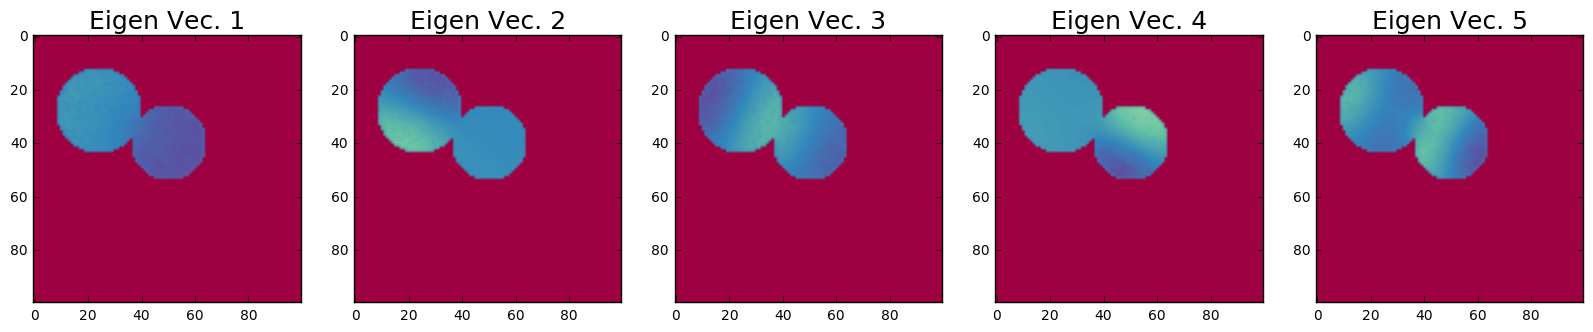

4 circles


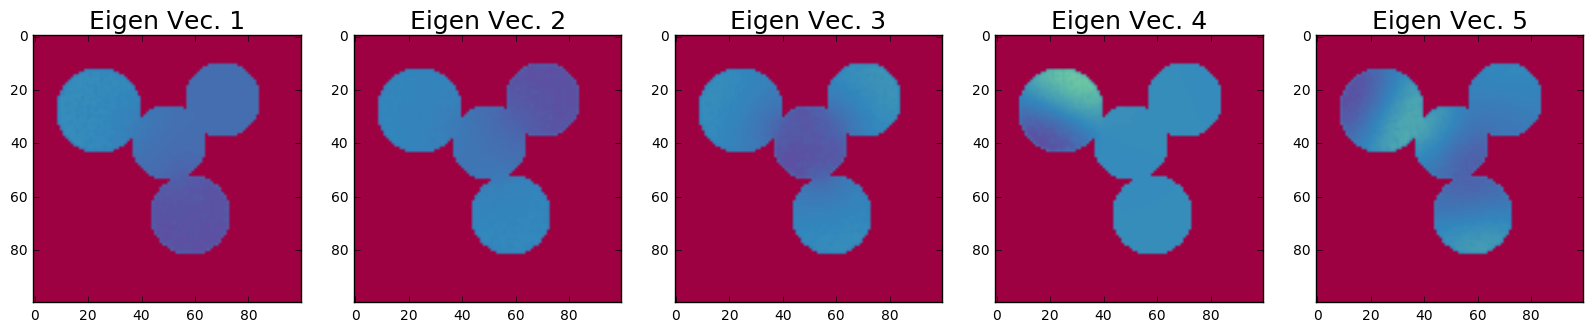

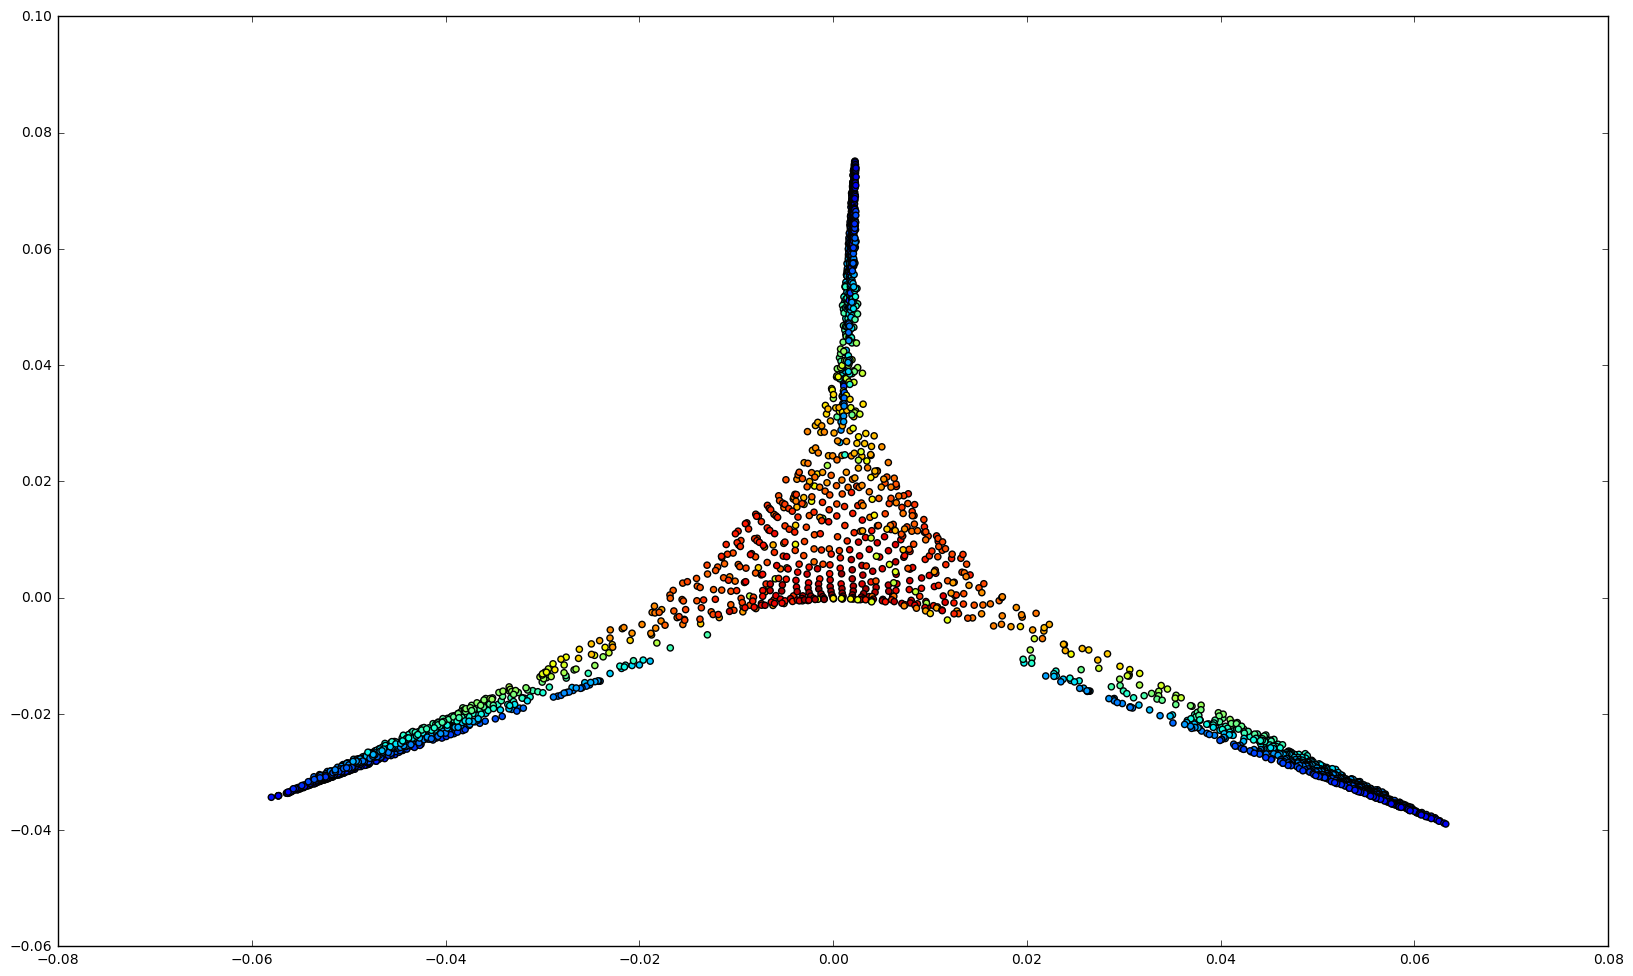

In [22]:

import pylab as pl
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.manifold import SpectralEmbedding
pl.rcParams['figure.figsize'] = 20,12

###############################################################################
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2


###############################################################################
# 2 circles
print ('2 circles')
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.1 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

se = SpectralEmbedding(n_components=5,affinity='precomputed')
Y = se.fit_transform(graph.toarray())

for j in range(0,se.n_components):
    pl.subplot(1,se.n_components, j+1)
    label_im = -np.ones(mask.shape)
    label_im[mask] = Y[:,j]
    pl.title('Eigen Vec. %i' % (j+1), size=18)
    pl.imshow(label_im,cmap=pl.cm.Spectral)
pl.show()

#pl.figure()
#pl.scatter(Y[:, 1], Y[:, 2], c=Y[:,0], cmap=pl.cm.Spectral)

# 4 circles
print ('4 circles')
img = circle1 + circle2 + circle3 + circle4
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.1 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependant from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())


se = SpectralEmbedding(n_components=5,affinity='precomputed')
Y = se.fit_transform(graph.toarray())

for j in range(0,se.n_components):
    pl.subplot(1,se.n_components, j+1)
    label_im = -np.ones(mask.shape)
    label_im[mask] = Y[:,j]
    pl.title('Eigen Vec. %i' % (j+1), size=18)
    pl.imshow(label_im,cmap=pl.cm.Spectral)
pl.show()

pl.figure()
pl.scatter(Y[:, 0], Y[:, 1], c=Y[:,2], cmap=pl.cm.jet)   


#### The famous Lena - Spectral Clustering

http://scikit-learn.org/0.15/auto_examples/cluster/plot_lena_segmentation.html

‘kmeans’ spectral clustering will cluster samples in the embedding space using a kmeans algorithm whereas ‘discrete’ will iteratively search for the closest partition space to the embedding space.


For hierarchical clustering: http://scikit-learn.org/0.15/auto_examples/cluster/plot_lena_ward_segmentation.html

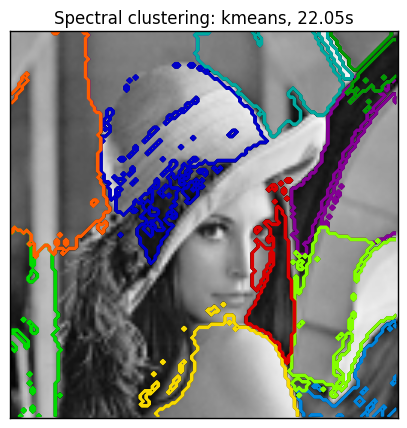

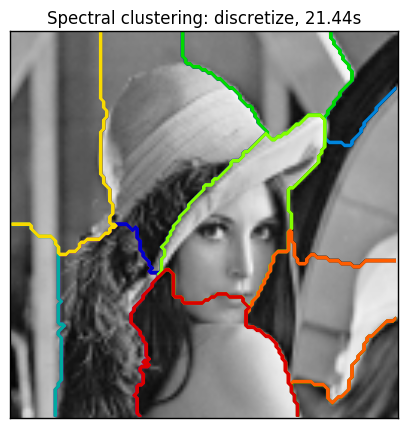

In [24]:
import time
import pickle
from numpy import array
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

# lena = sp.misc.lena()
'''
# Not working:         KeyError: '\n'
import urllib2
target_url = 'https://github.com/minrk/scipy-1/blob/master/scipy/misc/lena.dat'
data = urllib2.urlopen(target_url)
lena = array(pickle.loads(data.read()))
'''

fname = 'lena.dat'    # This file needs to be in same directory
f = open(fname,'rb')
lena = array(pickle.load(f))
f.close()

# Downsample the image by a factor of 4
lena = lena[::2, ::2] + lena[1::2, ::2] + lena[::2, 1::2] + lena[1::2, 1::2]
lena = lena[::2, ::2] + lena[1::2, ::2] + lena[::2, 1::2] + lena[1::2, 1::2]

# Convert the image into a graph with the value of the gradient on the edges.
graph = image.img_to_graph(lena)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / lena.std()) + eps

# Apply spectral clustering (this step goes much faster if you have pyamg installed)
N_REGIONS = 11

###############################################################################
# Visualize the resulting regions

for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=assign_labels,
                                 random_state=1)
    t1 = time.time()
    labels = labels.reshape(lena.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(lena,   cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0)))

plt.show()